## Python wrapper for Dynamic Causal Modelling and Parametric Empirical Bayes ##

This code implements a dynamic causal modelling analysis of effective network inference based on intracranial EEG data, using prior information from structural connectivity. 

### Housekeeping

In [5]:
# Import relevant packages
#================================================================================
import os
import sys
import time
import glob
from importlib import reload
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import mne
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report
import networkx as nx
import community

import pyCM 
# import python_DCM

In [6]:
# Define local folder structure
#================================================================================
F = {}
F['base'] = '/Volumes/GoogleDrive/My Drive/Research/2201_TVP-integ'
F['bids'] = F['base'] +os.sep+ '01_Data' +os.sep+ 'bids'
F['code'] = F['base'] +os.sep+ '02_Code'
F['outp'] = F['base'] +os.sep+ '03_Output'
print_dir_tree(F['bids'])

subject     = '72'
saveoutputs = True

|bids/
|--- dataset_description.json
|--- participants.tsv
|--- .ipynb_checkpoints/
|--- derivatives/
|------ struct-connect/
|--------- sub-72/
|------------ connectivity/
|--------------- sub-72-dwi_conndata-network_connectivity.csv
|--------------- sub-72-dwi_conndata-network_connectivity.tsv
|--- sub-72/
|------ ses-01/
|--------- sub-72_ses-01_scans.tsv
|--------- anat/
|------------ sub-72_ses-01_T1w.json
|------------ sub-72_ses-01_T1w.nii.gz
|--------- eeg/
|------------ sub-72_ses-01_task-spont_run-01_channels.tsv
|------------ sub-72_ses-01_task-spont_run-01_eeg.EDF
|------------ sub-72_ses-01_task-spont_run-01_eeg.json
|------------ sub-72_ses-01_task-spont_run-01_electrodes.tsv


### Loading relevant EEG data segments


In [7]:
reload(pyCM)
# Extract relevant data and descriptor files from BIDS
#----------------------------------------------------------------------------------
bids_path = BIDSPath(root=F['bids'],subject=subject,run=1,
                     datatype='eeg',session='01',task='spont')
eegpath   = str(bids_path)+'_eeg.EDF'
chans     = pd.read_csv(str(bids_path)+'_channels.tsv', sep='\t')
elect     = pd.read_csv(str(bids_path)+'_electrodes.tsv', sep='\t')

# Set up necessary folders
#----------------------------------------------------------------------------------
os.makedirs(F['outp']+os.sep+'preproc', exist_ok=True)
os.makedirs(F['outp']+os.sep+'dcm', exist_ok=True) 

# Extract epoches data from continuous recording
#----------------------------------------------------------------------------------
seeg = pyCM.dataload(eegpath, elect=elect, chans=chans, seg_type='uniform', 
                     window_secs=10, window_number=10)

if saveoutputs:
    scipy.io.savemat(F['outp']+os.sep+'preproc'+os.sep+'sub-'+subject+'_seeg_segmented.mat', 
                     {'seeg':seeg, 'subject':subject})

Extracting EDF parameters from /Volumes/GoogleDrive/My Drive/Research/2201_TVP-integ/01_Data/bids/sub-72/ses-01/eeg/sub-72_ses-01_task-spont_run-01_eeg.EDF...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Loading data for 10 events and 20481 original time points ...
0 bad epochs dropped
------------------
Data extracted 
Sampling: uniform
Epochs: 10 (10 seconds each)
Data resampled to 250Hz


### Identify representative subgroups of nodes

Resolution fixed at 0.7
Consensus partition with 10 communities


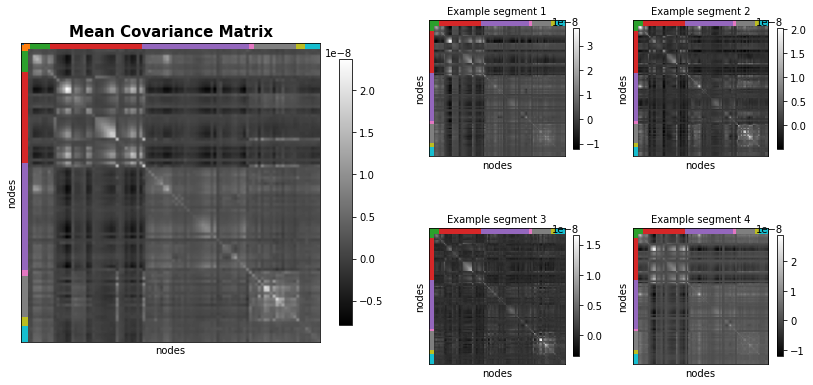

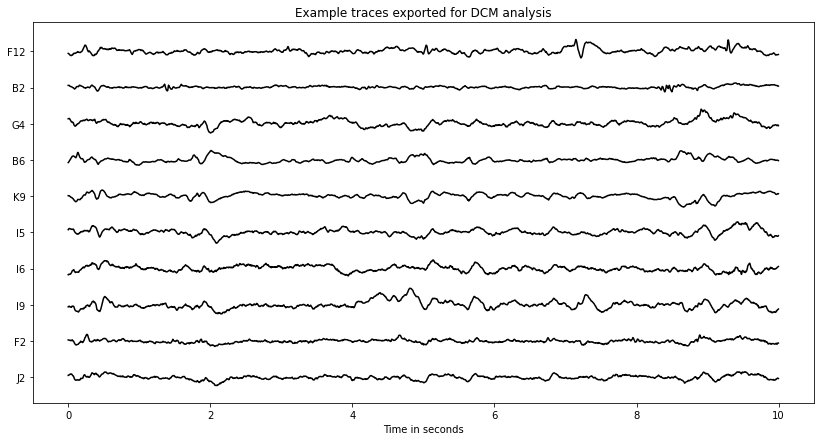

In [8]:
# Run partitioning
#----------------------------------------------------------------------------------
A, partition, nodelist = pyCM.node_selection(seeg)
scipy.io.savemat(F['outp']+os.sep+'preproc'+os.sep+'sub-'+subject+'_partition.mat', 
                 {'A':A, 'partition':partition,'nodelist':nodelist})

# Plot covariance structure in partition order
#----------------------------------------------------------------------------------
fig, ax = plt.subplot_mosaic([['m', 'm', 's1', 's2'],
                              ['m', 'm', 's3', 's4']], figsize=(14,7))
fig.patch.set_facecolor('white')
pyCM.plot_by_partition(np.mean(A, axis=0), partition, ax=ax['m'])
ax['m'].set_title('Mean Covariance Matrix', fontweight='bold', fontsize=15)
pyCM.plot_by_partition(A[0,:,:], partition, ax=ax['s1'])
ax['s1'].set_title('Example segment 1', fontsize=10)
pyCM.plot_by_partition(A[2,:,:], partition, ax=ax['s2'])
ax['s2'].set_title('Example segment 2', fontsize=10)
pyCM.plot_by_partition(A[4,:,:], partition, ax=ax['s3'])
ax['s3'].set_title('Example segment 3', fontsize=10)
pyCM.plot_by_partition(A[6,:,:], partition, ax=ax['s4'])
ax['s4'].set_title('Example segment 4', fontsize=10)

plt.show()

# Example segment plot
#-------------------------------------------------------------------------------------------
segtoplot = 3
f,a = plt.subplots(1,figsize=(14,7))
for ni in range(len(nodelist)):
    a.plot(seeg['time'], seeg['data'][segtoplot,nodelist[ni],:]-ni/1000, color='k')
a.set_yticks(-np.arange(0,len(nodelist)/1000,1/1000))
a.set_yticklabels([seeg['labels'][n] for n in nodelist])
a.set_xlabel('Time in seconds')
a.set_title('Example traces exported for DCM analysis')
plt.show()

In [39]:
# Collate data required to make SPM readable file
#------------------------------------------------------------------------------------------
# Warning: there are some issues with scipy matload and write - adding zero dimensons
# Corrected here by hand, but worth keeping in mind for future use

# Load data and reorganise
#------------------------------------------------------------------------------------------
d        = scipy.io.loadmat(F['outp']+os.sep+'preproc'+os.sep+'sub-'+subject+'_seeg_segmented.mat')
seeg     = d['seeg']
subject  = d['subject'][0]
data     = seeg['data'][0][0]
time     = seeg['time'][0][0][0]
Fs       = seeg['Fs'][0][0][0]

p        = scipy.io.loadmat(F['outp']+os.sep+'preproc'+os.sep+'sub-'+subject+'_partition.mat')
nodelist = p['nodelist'][0]
labels   = [seeg['labels'][0][0][n] for n in nodelist] 

#===========================================================================================
# Specify DCM variable that will be used for inversion
#===========================================================================================
dcm_path = F['outp']+os.sep+'dcm'+os.sep+'DCM_sub-'+subject
DCM      = pyCM.dcm_spec(dcm_path, labels, time, datatype='CSD', model='CMC', freq_range=[1,35])

# Pack up and save
#===========================================================================================
# For this analysis, in addition to the DCM dictionary specified above, we need
#     - data  a 3D (trials x channels x time) data file
#     - time, a 1D (time) time vector (encoding time in seconds)
#     - conds, a 1D (trials) list of condition labels
#     - labels, a 1D (channels) list of channel labels
data    = data[:,nodelist,:]
time    = time
conds   = ['spontaneous' for i in range(data.shape[0])]
labels  = labels

F['spec'] = F['outp']+os.sep+'dcm'+os.sep+'sub-'+subject+'_dcm_spec.mat'
if saveoutputs:
    scipy.io.savemat(F['spec'],
                     {'data':data,'time':time,'labels':labels, 'DCM':DCM, 'conds':conds, 
                      'Fbase':F['base'], 'subject':subject})

## Run DCM code using the Matlab Engine
This will use an existing and licensed Matlab Environment in order to run the specified DCM analysis. Currently this does not seem to work on teb newer M1 Apple Silicon Architecture. 

### Estimate cross spectral densities from the time series data

In [48]:
import matlab.engine

# Estimate cross spectral densities and return path for DCM object
#-------------------------------------------------------------------------------------------
M        = pyCM.start_matlab(F) 
F['dcm'] = M.pdcm_estimate_csd(F['spec'], nargout=1)
M.quit()

Data type is missing or incorrect, assigning default.
SPM M/EEG data object
Type: single
Transform: time
1 conditions
10 channels
2500 samples/trial
10 trials
Sampling frequency: 250 Hz
Loaded from file  /Volumes/GoogleDrive/My Drive/Research/2201_TVP-integ/01_Data/matlab/sub-72_SEEG.mat

Use the syntax D(channels, samples, trials) to access the data
Type "methods('meeg')" for the list of methods performing other operations with the object
Type "help meeg/method_name" to get help about methods


evaluating CSD for condition 1
CSD estimation complete


In [ ]:
reload(pyCM)
# Run DCM inversion
#-------------------------------------------------------------------------------------------
M = pyCM.start_matlab(F) 
M.pdcm_run_dcm(F['dcm'], nargout=0)
M.quit()

EM:(+): 1     F: 0.000e+00 dF predicted: 7.956e+02  actual: 2.843e+02 (112.71 sec)
EM:(+): 2     F: 2.843e+02 dF predicted: 1.103e+03  actual: 1.835e+02 (115.88 sec)
EM:(+): 3     F: 4.678e+02 dF predicted: 1.569e+03  actual: -1.584e+02 (117.20 sec)
EM:(-): 4     F: 4.678e+02 dF predicted: 4.022e+02  actual: 3.292e+02 (114.78 sec)
EM:(+): 5     F: 7.970e+02 dF predicted: 7.574e+02  actual: 1.085e+03 (133.67 sec)
EM:(+): 6     F: 1.882e+03 dF predicted: 7.387e+02  actual: -5.932e+02 (134.68 sec)
EM:(-): 7     F: 1.882e+03 dF predicted: 3.584e+02  actual: -8.897e+02 (133.68 sec)
EM:(-): 8     F: 1.882e+03 dF predicted: 6.866e+01  actual: 5.078e+01 (102.00 sec)
EM:(+): 9     F: 1.933e+03 dF predicted: 7.919e+01  actual: -9.129e+02 (130.95 sec)
EM:(-): 10     F: 1.933e+03 dF predicted: 1.148e+01  actual: 1.422e+01 (101.63 sec)
EM:(+): 11     F: 1.947e+03 dF predicted: 5.447e+01  actual: -5.648e+02 (131.61 sec)
EM:(-): 12     F: 1.947e+03 dF predicted: 7.699e+00  actual: 9.198e+00 (102.07 s

In [9]:
os.getcwd()

'/Volumes/GoogleDrive/My Drive/Research/2201_TVP-integ/02_Code'

Convert full connectivity to reduced prior sets

Invert full DCM

Run PEB to identify structure-function mapping

Results Figure

In [ ]:
ml = '/Applications/MATLAB_R2022a.app/bin/mwpython'
hw = '/Volumes/GoogleDrive/My Drive/Research/2201_TVP-integ/02_Code/hw.py'

In [10]:
! /Applications/MATLAB_R2022a.app/bin/mwpython /Volumes/GoogleDrive/My Drive/Research/2201_TVP-integ/02_Code/hw.py

dyld[67402]: Library not loaded: @rpath/libpython3.8.dylib
  Referenced from: /Applications/MATLAB_R2022a.app/bin/maci64/mwpython3.8.app/Contents/MacOS/mwpython3.8
  Reason: tried: './libpython3.8.dylib' (no such file), '/Applications/MATLAB_R2022a.app/runtime/maci64/libpython3.8.dylib' (no such file), '/libpython3.8.dylib' (no such file), '/Applications/MATLAB_R2022a.app/bin/maci64/libpython3.8.dylib' (no such file), '/Applications/MATLAB_R2022a.app/sys/os/maci64/libpython3.8.dylib' (no such file), '/libpython3.8.dylib' (no such file), '/libpython3.8.dylib' (no such file), '/libpython3.8.dylib' (no such file), '/Applications/MATLAB_R2022a.app/bin/maci64/mwpython3.8.app/Contents/MacOS/libpython3.8.dylib' (no such file), '/Applications/MATLAB_R2022a.app/bin/maci64/mwpython3.8.app/Contents/MacOS/./libpython3.8.dylib' (no such file), '/Applications/MATLAB_R2022a.app/bin/maci64/mwpython3.8.app/Contents/MacOS/../../../../../bin/maci64/libpython3.8.dylib' (no such file), '/Applications/MATLA